In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
# from torchvision import datasets, models
from torchvision import  transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
# from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data
from skimage import io
from skimage.transform import resize
# from sklearn.metrics import precision_score, recall_score, f1_score
from datetime import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv


In [2]:
plt.ion()  
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:
# Load environment variables from .env file
load_dotenv()

data_directory = os.getenv("DATASET1")


# all_files = os.listdir(data_directory)
# print(len(all_files))
# all_files = [f for f in all_files if f.endswith('.png') and f[-5] in ['0', '1']]
# print(len(all_files))
# # del(all_files[len(all_files) - 1])
# # print(all_files[len(all_files) - 1])

In [8]:
# verify existance of directory
if os.path.exists(data_directory):
    print("Directory exists")
    print(os.listdir(data_directory))
else:
    print("Directory does not exist:", data_directory)

Directory exists
['CHNCXR_0492_1.png', 'CHNCXR_0187_0.png', 'CHNCXR_0342_1.png', 'CHNCXR_0286_0.png', 'CHNCXR_0022_0.png', 'CHNCXR_0067_0.png', 'CHNCXR_0572_1.png', 'CHNCXR_0537_1.png', 'CHNCXR_0323_0.png', 'CHNCXR_0636_1.png', 'CHNCXR_0147_0.png', 'CHNCXR_0102_0.png', 'CHNCXR_0417_1.png', 'CHNCXR_0452_1.png', 'CHNCXR_0246_0.png', 'CHNCXR_0203_0.png', 'CHNCXR_0382_1.png', 'CHNCXR_0083_0.png', 'CHNCXR_0596_1.png', 'CHNCXR_0262_0.png', 'CHNCXR_0227_0.png', 'CHNCXR_0433_1.png', 'CHNCXR_0476_1.png', 'CHNCXR_0163_0.png', 'CHNCXR_0126_0.png', 'CHNCXR_0366_1.png', 'CHNCXR_0657_1.png', 'CHNCXR_0612_1.png', 'CHNCXR_0307_0.png', 'CHNCXR_0556_1.png', 'CHNCXR_0513_1.png', 'CHNCXR_0006_0.png', 'CHNCXR_0043_0.png', 'CHNCXR_0218_0.png', 'CHNCXR_0399_1.png', 'CHNCXR_0119_0.png', 'CHNCXR_0364_1.png', 'CHNCXR_0449_1.png', 'CHNCXR_0004_0.png', 'CHNCXR_0041_0.png', 'CHNCXR_0554_1.png', 'CHNCXR_0511_1.png', 'CHNCXR_0305_0.png', 'CHNCXR_0655_1.png', 'CHNCXR_0610_1.png', 'CHNCXR_0594_1.png', 'CHNCXR_0081_0.p

In [9]:
all_files = os.listdir(data_directory)
all_files = [f for f in all_files if f.endswith('.png') and f[-5] in ['0', '1']] # filtering for images with 0 and 1
print("Valid images:" ,len(all_files))

Valid images: 662


In [10]:
device = None
if torch.backends.mps.is_available():
    device = torch.device('mps')  
elif torch.xpu.is_available():
    device = torch.device("xpu")
    print("Using Intel GPU")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using NVIDIA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
print("Device Category: ",device)

Device Category:  mps


In [11]:
# all_files = np.array(all_files)
# #singlechannel_files = np.array(singlechannel_files)
# np.random.shuffle(all_files)

# train_files = all_files[:round(0.7*all_files.shape[0])]
# test_files = all_files[round(0.7*all_files.shape[0]):]
# # print(all_files[0])
# # print(all_files[0][-5])

# count = 0
# for i in train_files:
#     if(i[-5] == '0'):
#         count += 1

# print(count)
# print(len(train_files))

all_files = np.array(all_files)
print(all_files.shape)
np.random.shuffle(all_files)

# Split our data: 70% for training, 30% for testing
# Determine the split index for 70% of the data
split_index = int(0.70 * len(all_files))
train_files = all_files[:split_index]
test_files = all_files[split_index:]
print(train_files.shape, test_files.shape)


(662,)
(463,) (199,)


In [12]:
print(len(train_files))
print(len(test_files))

463
199


In [13]:
categories = {'0':0,'1':0}
for file in test_files:
    categories[file[-5]] += 1

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([ transforms.ToTensor()])

In [14]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
# Custom loader function
def CNNloader(data_root, filename):
    filename_actual = os.path.join(data_root, filename)
    data_old = io.imread(filename_actual)
    data_old = resize(data_old, (224, 224))
    data_old = np.array(data_old, dtype=np.float32)
    
    if len(data_old.shape) <= 2:
        data_new = np.zeros((224, 224, 3))
        data_new[:,:,0] = data_new[:,:,1] = data_new[:,:,2] = np.array(data_old)
        data_old = np.array(data_new, dtype=np.float32)
    
    data_old = data_transforms(np.array(data_old))
    return data_old

In [16]:
# Custom Dataset class
class CNNDataLayer(data.Dataset):
    def __init__(self, data_root, filenames, loader):
        self.data_root = data_root
        self.filenames = filenames
        self.loader = loader

    def __getitem__(self, index):
        filename = self.filenames[index]
        target = int(filename[-5])  # Assuming the label is the second-to-last character
        target = torch.tensor([target], dtype=torch.float32)
        data = self.loader(self.data_root, filename)
        return data, target

    def __len__(self):
        return len(self.filenames)


In [17]:
# Create datasets
data_sets_train = CNNDataLayer(data_root=data_directory, filenames=train_files, loader=CNNloader)
data_sets_test = CNNDataLayer(data_root=data_directory, filenames=test_files, loader=CNNloader)

# Create data loaders
data_loaders_train = data.DataLoader(
    data_sets_train,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)
data_loaders_test = data.DataLoader(
    data_sets_test,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

image_datasets = {'train': data_sets_train, 'val': data_sets_test}
dataloaders = {'train': data_loaders_train, 'val': data_loaders_test}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = ['NoTB', 'TB']

print(f"Training set size: {dataset_sizes['train']}")
print(f"Validation set size: {dataset_sizes['val']}")
print(f"Batch size: {dataloaders['train'].batch_size}")

Training set size: 463
Validation set size: 199
Batch size: 8


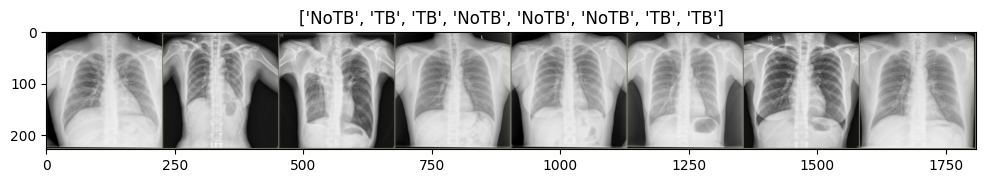

In [18]:

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  



inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(12, 6))
imshow(out, title=[class_names[int(x.item())] for x in classes])
plt.show()

In [19]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

    return(output)

outputSize(224,2,2,0)

112

In [20]:
class SimpleCNN(torch.nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = torch.nn.Sequential(torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1), 
                                            torch.nn.ReLU(inplace = True), 
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                                            torch.nn.Conv2d(18, 20, kernel_size=3, stride=1, padding=1), 
                                            torch.nn.ReLU(inplace = True), 
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                                            torch.nn.Conv2d(20, 32, kernel_size=3, stride=1, padding=1), 
                                            torch.nn.ReLU(inplace = True), 
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),)
        
        self.classifier = torch.nn.Sequential(torch.nn.Linear(32 * 28 * 28, 64), 
                                              torch.nn.ReLU(inplace = True), 
                                              torch.nn.Linear(64, 1), 
                                              torch.nn.Sigmoid())

    def forward(self, x):
        
        # passing the input images through the convolutional layers
        x = self.features(x)
        
        #Flattening the output of the convolutional layers
        x = x.view(-1, 32 * 28 * 28)
        
        #Computes the activation of the first fully connected layer
        x = self.classifier(x)
        
        return(x)
    

    def num_flat_features(self, x):
        
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    now = datetime.now()
    Saved_path = "OWNCNN-output" + "/" + now.strftime("%Y-%m-%d_%H-%M-%S")
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch is ' + str(epoch))
        # train_loss = 0
        # test_loss = 0
        total_misclassified_train = 0
        total_count_train = 0
        total_misclassified_test = 0
        total_count_test = 0
        total_false_negatives_train = 0
        total_false_positives_train = 0
        total_false_negatives_test = 0
        total_false_positives_test = 0
        for data_now, target_now in dataloaders['train']:


            model.train()  
            data_now = data_now.to(device)
            target_now = target_now.type(torch.FloatTensor)
            target_now = target_now.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                target_output_model = model(data_now)
                target_loss = criterion(target_output_model, target_now)
                target_loss.backward()
                optimizer.step()
                
            misclassified_temp = target_output_model[target_now == 1]
            false_negatives_train = misclassified_temp[misclassified_temp < 0.5].size()[0]
            misclassified_temp = target_output_model[target_now == 0]
            false_positives_train = misclassified_temp[misclassified_temp >= 0.5].size()[0]
            total_misclassified_train += false_negatives_train + false_positives_train
            total_false_positives_train += false_positives_train
            total_false_negatives_train += false_negatives_train
            total_count_train += data_now.shape[0]
        
        #  testing mode
        for data_now, target_now in dataloaders['val']:
            model.eval()   
            
            
            data_now = data_now.to(device)
            target_now = target_now.to(device)

            with torch.set_grad_enabled(False):
                target_output_model = model(data_now)
                
            misclassified_temp = target_output_model[target_now == 1]
            false_negatives_test = misclassified_temp[misclassified_temp < 0.5].size()[0]
            misclassified_temp = target_output_model[target_now == 0]
            false_positives_test = misclassified_temp[misclassified_temp >= 0.5].size()[0]
            total_misclassified_test += false_negatives_test + false_positives_test
            total_false_positives_test += false_positives_test
            total_false_negatives_test += false_negatives_test
            total_count_test += data_now.shape[0]

        epoch_loss = total_misclassified_train / total_count_train
        epoch_acc = (total_count_train - total_misclassified_train) / total_count_train
        print("Classified " + str(total_count_train - total_misclassified_train) + " out of " + str(total_count_train) + " correctly.")
        print('{} Loss: {:.4f} Acc: {:.4f} False Positives: {} False Negatives: {}'.format(
            'train', epoch_loss, epoch_acc, total_false_positives_train, total_false_negatives_train))

        epoch_loss = total_misclassified_test / total_count_test
        epoch_acc = (total_count_test - total_misclassified_test) / total_count_test
        print("Classified " + str(total_count_test - total_misclassified_test) + " out of " + str(total_count_test) + " correctly.")
        print('{} Loss: {:.4f} Acc: {:.4f} False Positives: {} False Negatives: {}'.format(
            'val', epoch_loss, epoch_acc, total_false_positives_test, total_false_negatives_test))

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

        #Saving the weights now
        # snapshot_path = './snapshotsOwnCNN'
        if not os.path.isdir(Saved_path):
            os.makedirs(Saved_path)
        epoch_model_name = 'epoch-{}-trainerror-{}-testerror-{}.pth'.format(epoch, 
                               float(total_misclassified_train / total_count_train),
                               float(total_misclassified_test / total_count_test))
        
        torch.save(model.state_dict(), os.path.join(Saved_path, epoch_model_name))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [75]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()  
    
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Apply sigmoid for binary classification
            preds = torch.sigmoid(outputs)  
            preds = preds > 0.5  # Convert probabilities to binary predictions
            
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)  # Restore training mode
                    return

                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                predicted_label = int(preds[j])   # Convert tensor to integer index
                true_label = int(labels[j])        # Convert tensor to integer index

                ax.set_title(f'Predicted: {class_names[predicted_label]} | True: {class_names[true_label]}')
                imshow(inputs.cpu().data[j])

        model.train(mode=was_training)  # Restore training mode after visualization

Epoch is 0
Classified 293 out of 463 correctly.
train Loss: 0.3672 Acc: 0.6328 False Positives: 141 False Negatives: 29
Classified 141 out of 199 correctly.
val Loss: 0.2915 Acc: 0.7085 False Positives: 16 False Negatives: 42

Epoch is 1
Classified 353 out of 463 correctly.
train Loss: 0.2376 Acc: 0.7624 False Positives: 49 False Negatives: 61
Classified 151 out of 199 correctly.
val Loss: 0.2412 Acc: 0.7588 False Positives: 20 False Negatives: 28

Epoch is 2
Classified 382 out of 463 correctly.
train Loss: 0.1749 Acc: 0.8251 False Positives: 19 False Negatives: 62
Classified 148 out of 199 correctly.
val Loss: 0.2563 Acc: 0.7437 False Positives: 16 False Negatives: 35

Epoch is 3
Classified 384 out of 463 correctly.
train Loss: 0.1706 Acc: 0.8294 False Positives: 18 False Negatives: 61
Classified 154 out of 199 correctly.
val Loss: 0.2261 Acc: 0.7739 False Positives: 17 False Negatives: 28

Epoch is 4
Classified 385 out of 463 correctly.
train Loss: 0.1685 Acc: 0.8315 False Positives:

/var/folders/bt/f868ty6d66g2scxrj62lpgzc0000gn/T/ipykernel_95668/3564022132.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = int(preds[j])   # Convert tensor to integer index
/var/folders/bt/f868ty6d66g2scxrj62lpgzc0000gn/T/ipykernel_95668/3564022132.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[j])        # Convert tensor to integer index


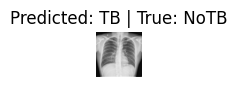

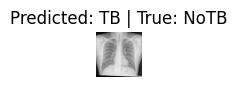

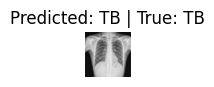

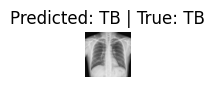

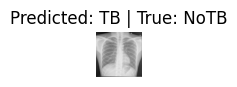

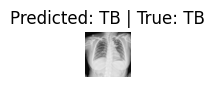

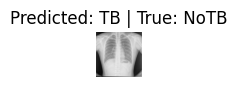

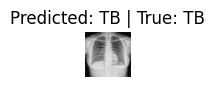

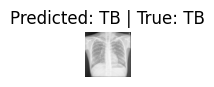

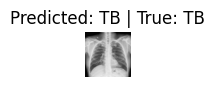

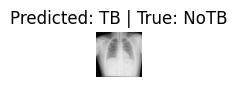

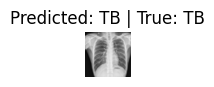

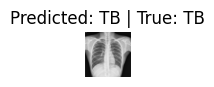

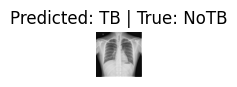

In [76]:
model_ft = SimpleCNN()

model_ft = model_ft.to(device)

criterion = nn.BCELoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.006, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

visualize_model(model_ft, 14)

In [77]:
#  running over testing files to print number of True positives, True negatives, False positives, False negatives
# Function to evaluate the model and generate predictions
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = (outputs > 0.5).float()  # Apply threshold for binary classification

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


In [79]:
test_loader = data_loaders_test  

# Get true labels and predictions
true_labels, predictions = evaluate_model(model_ft, test_loader)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)


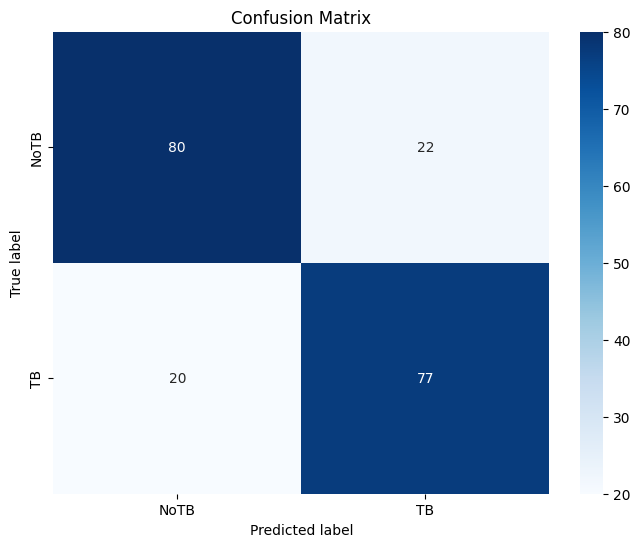

In [80]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Class names for your dataset (update as necessary)
class_names = ['NoTB', 'TB']
plot_confusion_matrix(cm, class_names)